In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Stable Diffusion V2.1

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
    (a Python-3 GPU notebook with preinstalled HuggingFace/transformer libraries is recommended)
  </td>
</table>

## Overview

This notebook demonstrates running local inference for [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1) on either [Colab](https://colab.research.google.com) or [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench). This notebook also demonstrates finetuning stabilityai/stable-diffusion-2-1 with [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth) and deploying it on Vertex AI for online prediction.

### Objective

- Run local predictions for text-to-image and text-guided-image-to-image with serving dockers.
- Finetune the stabilityai/stable-diffusion-2-1 model with [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth).
- Upload the model to [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model to a [Vertex AI Endpoint resource](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for text-to-image and text-guided-image-to-image.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

**NOTE**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Setup notebook

#### Workbench only
1.   Follow [this link](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb) to deploy the notebook to a Vertex AI Workbench Instance.
2.   Select `Create a new Notebook`.
3.   Click `Advanced Options`.
4.   In the **Environment** tab, select `Debian 10` for **Operating System** and select `Custom Container` for **Environment**.
5.   Set `Docker container image` to `us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/transformers-notebook`.
6.   Under **Machine configuration**, select 1 `T4` GPU and select `Install NVIDIA GPU driver automatically for me`.
7.   Click `Create` to create the Vertex AI Workbench instance.

### Setup Google Cloud project

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.

1. [Create a service account](https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console) with `Vertex AI User` and `Storage Object Admin` roles for deploying fine tuned model to Vertex AI endpoint.

Fill following variables for experiments environment:

In [2]:
import socket
import re

UNIQUE_PREFIX = socket.gethostname()
UNIQUE_PREFIX = re.sub('[^A-Za-z0-9]+', '', UNIQUE_PREFIX)

# Cloud project id.
PROJECT_IDS = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_IDS[0]  # @param {type:"string"}

# The region you want to launch jobs in.
PREFIX_NUM_ONLY=int(str(re.search(r'\d+', UNIQUE_PREFIX).group()))
REGION_ALLOCATE=PREFIX_NUM_ONLY%3
if REGION_ALLOCATE == 0:
    REGION = "asia-southeast1"
elif REGION_ALLOCATE == 1:
    REGION = "asia-south1"
else:
    REGION = "us-east4"

# The Cloud Storage bucket for storing experiments output. Fill it without the 'gs://' prefix.
GCS_BUCKET = f"{PROJECT_ID}-{UNIQUE_PREFIX}"  # @param {type:"string"} 
BUCKET_URI = f"gs://{GCS_BUCKET}"  # @param {type:"string"}

# The service account for deploying fine tuned model.
SERVICE_ACCOUNT = !(gcloud config get-value core/account)  # @param {type:"string"}
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]

! gcloud storage buckets create {BUCKET_URI} --project={PROJECT_ID} --location={REGION}
! pip install -q gdown

Creating gs://mythical-lens-406709-stablediffusiontest3/...


Initialize Vertex-AI API:

In [3]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

### Define constants

In [4]:
# The pre-built training docker images. They contain training scripts and models.
TRAIN_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-peft-train:20240318_0936_RC00"
# The pre-built serving docker images. They contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-diffusers-serve-opt:20240403_0836_RC00"

### Define common functions

In [5]:
import base64
import glob
import os
from datetime import datetime
from io import BytesIO

import requests
from google.cloud import aiplatform, storage
from PIL import Image

def create_job_name(prefix):
    user = os.environ.get("USER")
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    job_name = f"{prefix}-{user}-{now}"
    return job_name


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def image_to_base64(image, format="JPEG"):
    buffer = BytesIO()
    image.save(buffer, format=format)
    image_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return image_str


def base64_to_image(image_str):
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def base64_to_jpg(image_str):
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    with BytesIO() as output_buffer:
        jpg_data = output_buffer.getvalue()
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def deploy_model(model_id, task):
    model_name = model_id
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-{task}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "TASK": task,
    }
    model = aiplatform.Model.upload(
        display_name=f"{model_name}-{task}-model",
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/diffusers_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type="g2-standard-8",
        accelerator_type="NVIDIA_L4",
        accelerator_count=1,
        deploy_request_timeout=1800,
        service_account=SERVICE_ACCOUNT,
    )
    return model, endpoint


def get_bucket_and_blob_name(filepath):
    # The gcs path is of the form gs://<bucket-name>/<blob-name>
    gs_suffix = filepath.split("gs://", 1)[1]
    return tuple(gs_suffix.split("/", 1))


def upload_local_dir_to_gcs(local_dir_path, gcs_dir_path):
    """Uploads files in a local directory to a GCS directory."""
    client = storage.Client()
    bucket_name = gcs_dir_path.split("/")[2]
    bucket = client.get_bucket(bucket_name)
    for local_file in glob.glob(local_dir_path + "/**"):
        if not os.path.isfile(local_file):
            continue
        filename = local_file[1 + len(local_dir_path) :]
        gcs_file_path = os.path.join(gcs_dir_path, filename)
        _, blob_name = get_bucket_and_blob_name(gcs_file_path)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(local_file)
        print("Copied {} to {}.".format(local_file, gcs_file_path))

## Finetune with Dreambooth

This section uses [dreambooth](https://dreambooth.github.io/) to finetune the [stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1) model with [5 dog images](https://drive.google.com/drive/folders/1BO_dyz-p65qhBRRMRA4TbZ8qW4rB99JZ) to personalize the text-to-image model.

It finetunes both text encoder and unet of the stable diffusion model up to 800 steps. The whole finetuning job takes 45 minutes to finish using 1 A100 GPU.

The full model will be saved after the finetuning job finishs and it can be loaded by the [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img) to run inference.

In [6]:
# Download example training images.
!gdown --folder https://drive.google.com/drive/folders/1BO_dyz-p65qhBRRMRA4TbZ8qW4rB99JZ

# Upload data to Cloud Storage bucket.
upload_local_dir_to_gcs("dog", f"gs://{GCS_BUCKET}/dreambooth/dog")
upload_local_dir_to_gcs("dog", f"gs://{GCS_BUCKET}/dreambooth/dog_class")

Retrieving folder contents
Processing file 1aIWXIj3iB-7CfRFLROHq9U09EdrpUH-T alvan-nee-9M0tSjb-cpA-unsplash.jpeg
Processing file 15IDLUW4Jpwot_xVpWWVyCONWpiBBpQIi alvan-nee-bQaAJCbNq3g-unsplash.jpeg
Processing file 1FYFAp1sFfYh7I2eDcLK_BP7diKgGQib_ alvan-nee-brFsZ7qszSY-unsplash.jpeg
Processing file 1zonwTmg7Ggl_w2ELQyTDVNkjtQTlsDq4 alvan-nee-eoqnr8ikwFE-unsplash.jpeg
Processing file 1vI0QwqfGyWNdloy0L9N4Gz4qN3_BduwL alvan-nee-Id1DBHv4fbg-unsplash.jpeg
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1aIWXIj3iB-7CfRFLROHq9U09EdrpUH-T
To: /home/jupyter/dog/alvan-nee-9M0tSjb-cpA-unsplash.jpeg
100%|█████████████████████████████████████████| 677k/677k [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=15IDLUW4Jpwot_xVpWWVyCONWpiBBpQIi
To: /home/jupyter/dog/alvan-nee-bQaAJCbNq3g-unsplash.jpeg
100%|███████████████████████████████████████| 1.40M/1.40M [00:00<00:0

**NOTE**: If the upload step fails due to lacking of permission, you need to [grant the Storage Object Admin role](https://cloud.google.com/storage/docs/access-control/using-iam-permissions) for the Cloud account of the notebook.

In [7]:
# The pre-trained model to be loaded.
model_id = "stabilityai/stable-diffusion-2-1"

# Input and output path.
instance_dir = f"/gcs/{GCS_BUCKET}/dreambooth/dog"
class_dir = f"/gcs/{GCS_BUCKET}/dreambooth/dog_class"
output_dir = f"/gcs/{GCS_BUCKET}/dreambooth/output"

# Worker pool spec.
machine_type = "a2-highgpu-1g"
num_nodes = 1
gpu_type = "NVIDIA_TESLA_A100"
num_gpus = 1

# Pass training arguments and launch job.
# See https://github.com/huggingface/diffusers/blob/v0.14.0/examples/dreambooth/train_dreambooth.py#L75
# for a full list of training arguments.


def train_model_with_config(num_nodes, machine_type, gpu_type, num_gpus ):

    # Setup training job.
    job_name = create_job_name("dreambooth-stable-diffusion")
    job = aiplatform.CustomContainerTrainingJob(
        display_name=job_name,
        container_uri=TRAIN_DOCKER_URI,
    )
    try:
        model = job.run(
        args=[
            "--task=text-to-image-dreambooth",
            f"--pretrained_model_name_or_path={model_id}",
            f"--instance_data_dir={instance_dir}",
            f"--class_data_dir={class_dir}",
            f"--output_dir={output_dir}",
            "--mixed_precision=fp16",
            "--instance_prompt='a photo of sks dog'",
            "--resolution=768",
            "--train_batch_size=1",
            "--gradient_accumulation_steps=1",
            "--gradient_checkpointing",
            "--learning_rate=2e-6",
            "--lr_scheduler=constant",
            "--lr_warmup_steps=0 ",
            "--use_8bit_adam",
            "--max_train_steps=200",
            "--checkpointing_steps=100",
            "--seed=0",
        ],
        replica_count=num_nodes,
        machine_type=machine_type,
        accelerator_type=gpu_type,
        accelerator_count=num_gpus,
    )
    except Exception as e:
        print(f"Error: {e}")
        job.delete()
    return(model)



try:
    # Code that might potentially cause an error
    machine_type = "a2-highgpu-1g"
    num_nodes = 1
    gpu_type = "NVIDIA_TESLA_A100"
    num_gpus = 1
    model = train_model_with_config(num_nodes, machine_type, gpu_type, num_gpus)
except :  # Replace 'ErrorType' with the specific error you want to catch 
    try : 
        print("Error may becaused due to machine unavailable - A100s - trying L4s ")
        machine_type = "g2-standard-96"
        num_nodes = 1
        gpu_type = "NVIDIA_L4"
        num_gpus = 8
        model = train_model_with_config(num_nodes, machine_type, gpu_type, num_gpus)
    except :
        print("Error may becaused due to machine unavailable - L4s also - trying A100s again ")
        machine_type = "a2-highgpu-1g"
        num_nodes = 1
        gpu_type = "NVIDIA_TESLA_A100"
        num_gpus = 1
        model = train_model_with_config(num_nodes, machine_type, gpu_type, num_gpus)
else:
    # Code to execute if there's no error in the 'try' block
    print("Error may becaused due to machine unavailable of any type ")

    

Training Output directory:
gs://mythical-lens-406709-stablediffusiontest3/aiplatform-custom-training-2024-04-29-10:23:44.770 
View Training:
https://console.cloud.google.com/ai/platform/locations/asia-southeast1/training/7929034095462449152?project=599987431781
CustomContainerTrainingJob projects/599987431781/locations/asia-southeast1/trainingPipelines/7929034095462449152 current state:
PipelineState.PIPELINE_STATE_RUNNING
View backing custom job:
https://console.cloud.google.com/ai/platform/locations/asia-southeast1/training/5409410841437011968?project=599987431781
CustomContainerTrainingJob projects/599987431781/locations/asia-southeast1/trainingPipelines/7929034095462449152 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomContainerTrainingJob projects/599987431781/locations/asia-southeast1/trainingPipelines/7929034095462449152 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomContainerTrainingJob projects/599987431781/locations/asia-southeast1/trainingPipelines/7929

### Text-to-image fine-tuned Deployment

Deploy the stable diffusion model for the `text-to-image` task.

Once deployed, you can send a batch of text prompts to the endpoint to generated images.

When deployed on one `NVIDIA_L4` GPU, the averaged inference time of a request is ~3-4 seconds.

In [8]:
text_to_image_finetune_model, text_to_image_finetune_endpoint = deploy_model(
    model_id=f"gs://{GCS_BUCKET}/dreambooth/output", task="text-to-image"
)

Creating Endpoint
Create Endpoint backing LRO: projects/599987431781/locations/asia-southeast1/endpoints/3582323232503496704/operations/6986339763842187264
Endpoint created. Resource name: projects/599987431781/locations/asia-southeast1/endpoints/3582323232503496704
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/599987431781/locations/asia-southeast1/endpoints/3582323232503496704')
Creating Model
Create Model backing LRO: projects/599987431781/locations/asia-southeast1/models/3882973692002566144/operations/6177380680775761920
Model created. Resource name: projects/599987431781/locations/asia-southeast1/models/3882973692002566144@1
To use this Model in another session:
model = aiplatform.Model('projects/599987431781/locations/asia-southeast1/models/3882973692002566144@1')
Deploying model to Endpoint : projects/599987431781/locations/asia-southeast1/endpoints/3582323232503496704
Deploy Endpoint model backing LRO: projects/599987431781/locations/asia-sou

### Generate an Image from a prompt using fine-tuned text to image

Enter a prompt to generate images fine-tuned to dogs using Stable Diffusion

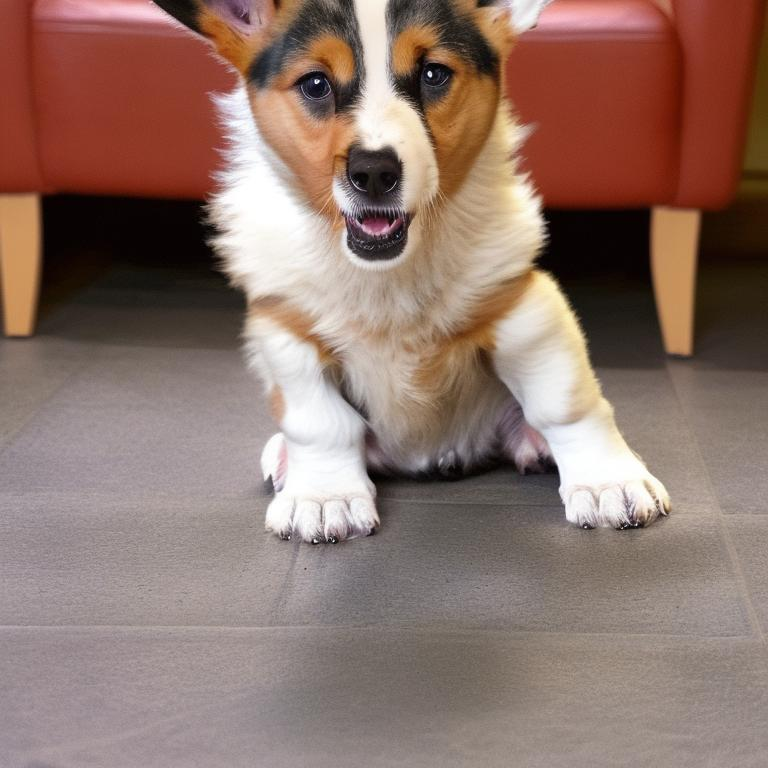

In [10]:
prompt = "A picture of a sks dog in a house"  # @param {type: "string"}
height = 768  # @param {type:"number"}
width = 768  # @param {type:"number"}
num_inference_steps = 25  # @param {type:"number"}
guidance_scale = 7.5  # @param {type:"number"}

instances = [
    {
        "prompt": prompt,
        "negative_prompt": "",
        "height": height,
        "width": width,
        "num_inference_steps": num_inference_steps,
        "guidance_scale": guidance_scale,
    }
]
response = text_to_image_finetune_endpoint.predict(instances=instances)
generated_image = [base64_to_image(image) for image in response.predictions]
display(generated_image[0])

## Upload and Deploy Base models

This section uploads the model to Model Registry and deploys it on the Endpoint.

The model deployment step will take ~15 minutes to complete. 

The first request requires some additional time for model compilation (up to a
few minutes), but the future requests should be processed much faster.

### Text-to-image Deployment

Deploy the stable diffusion model for the `text-to-image` task.

Once deployed, you can send a batch of text prompts to the endpoint to generated images.

When deployed on one `NVIDIA_L4` GPU, the averaged inference time of a request is ~3-4 seconds.

In [11]:
text_to_image_model, text_to_image_endpoint = deploy_model(
    model_id="stabilityai/stable-diffusion-2-1", task="text-to-image"
)

Creating Endpoint
Create Endpoint backing LRO: projects/599987431781/locations/asia-southeast1/endpoints/3508013838651883520/operations/1090564901660786688
Endpoint created. Resource name: projects/599987431781/locations/asia-southeast1/endpoints/3508013838651883520
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/599987431781/locations/asia-southeast1/endpoints/3508013838651883520')
Creating Model
Create Model backing LRO: projects/599987431781/locations/asia-southeast1/models/8494659710429954048/operations/8483223689989455872
Model created. Resource name: projects/599987431781/locations/asia-southeast1/models/8494659710429954048@1
To use this Model in another session:
model = aiplatform.Model('projects/599987431781/locations/asia-southeast1/models/8494659710429954048@1')
Deploying model to Endpoint : projects/599987431781/locations/asia-southeast1/endpoints/3508013838651883520
Deploy Endpoint model backing LRO: projects/599987431781/locations/asia-sou

NOTE: The model weights will be downloaded after the deployment succeeds. Thus upto 10 minutes of additional waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

### Text-guided image-to-image Deployment
Deploy the stable diffusion model for the text-guided image-to-image task.

In [12]:
image_to_image_model, image_to_image_endpoint = deploy_model(
    model_id="stabilityai/stable-diffusion-2-1", task="image-to-image"
)

Creating Endpoint
Create Endpoint backing LRO: projects/599987431781/locations/asia-southeast1/endpoints/3933604003438395392/operations/2720867966768906240
Endpoint created. Resource name: projects/599987431781/locations/asia-southeast1/endpoints/3933604003438395392
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/599987431781/locations/asia-southeast1/endpoints/3933604003438395392')
Creating Model
Create Model backing LRO: projects/599987431781/locations/asia-southeast1/models/1685217073845764096/operations/8417921495392583680
Model created. Resource name: projects/599987431781/locations/asia-southeast1/models/1685217073845764096@1
To use this Model in another session:
model = aiplatform.Model('projects/599987431781/locations/asia-southeast1/models/1685217073845764096@1')
Deploying model to Endpoint : projects/599987431781/locations/asia-southeast1/endpoints/3933604003438395392
Deploy Endpoint model backing LRO: projects/599987431781/locations/asia-sou

NOTE: The model weights will be downloaded after the deployment succeeds. Thus additional 5 minutes of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

## Generating Images with Stable Diffusion


### Generate an Image from a prompt using text to image

Enter a prompt to generate an image using Stable Diffusion

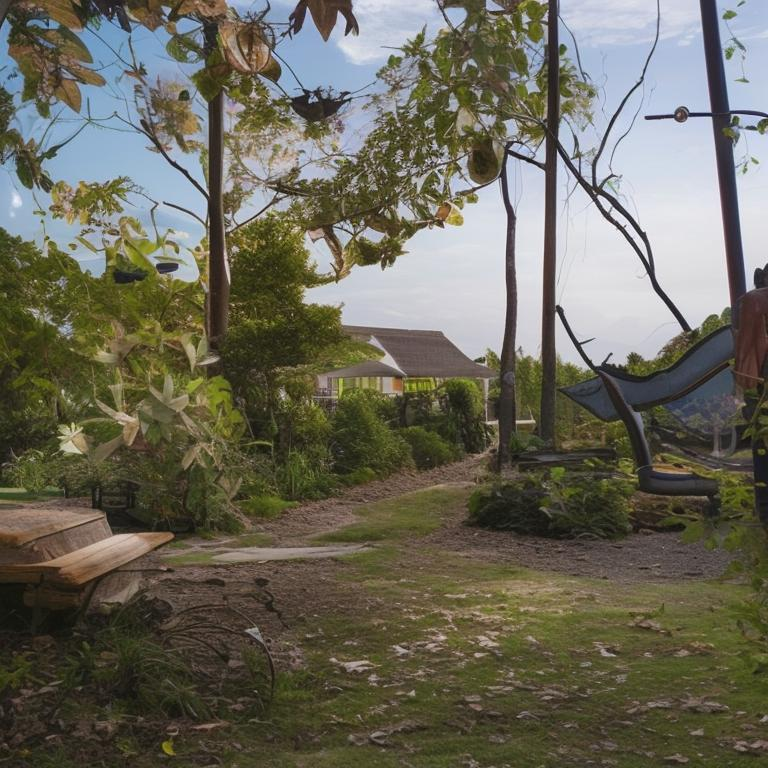

In [13]:
prompt = "A peaceful park"

instances = [
    {"prompt": prompt}
]
response = text_to_image_endpoint.predict(instances=instances)
generated_image = [base64_to_image(image) for image in response.predictions]
display(generated_image[0])

### Generate an image from a reference image and prompt using image to image

Enter a new prompt on how you want to edit the image generated above. \
The strength refers to the amount of deviation from the original image in a range from 0.0 to 1.0 with 0 being no change

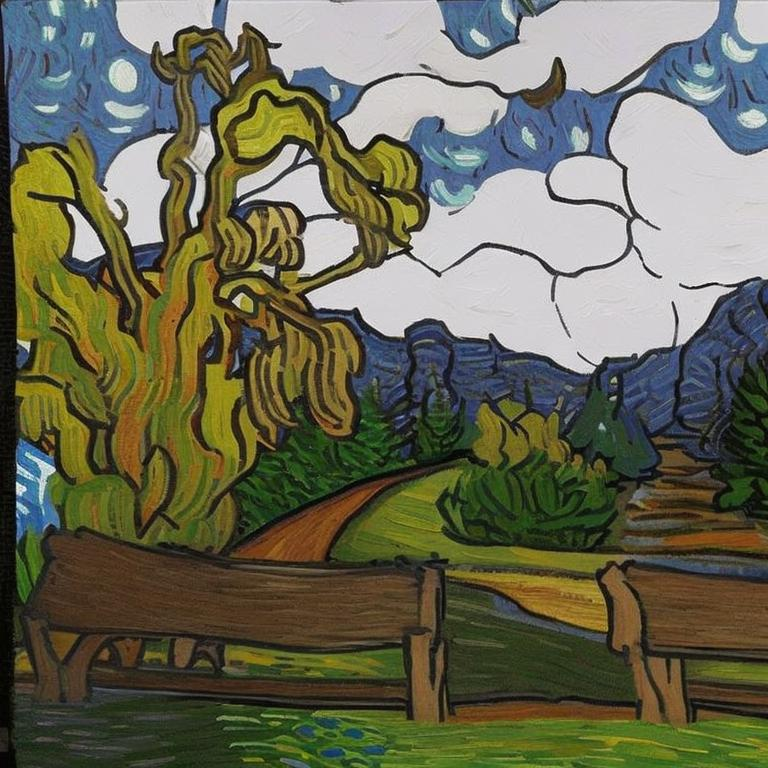

In [14]:
prompt = "A peaceful park in a van gogh style"
strength = 0.4

init_image = image_to_base64(generated_image[0])

instances = [
    {
        "prompt": prompt,
        "image": init_image,
        "strength": strength
    },
]

response = image_to_image_endpoint.predict(instances=instances)
image = [base64_to_image(image) for image in response.predictions]
display(image[0])

## Cleanup

Clean up resources:

In [15]:
# # Undeploy model and delete endpoint.
# text_to_image_finetune_endpoint.delete(force=True)

# # Delete models.
# text_to_image_finetune_model.delete()

Undeploying Endpoint model: projects/599987431781/locations/asia-southeast1/endpoints/3582323232503496704
Undeploy Endpoint model backing LRO: projects/599987431781/locations/asia-southeast1/endpoints/3582323232503496704/operations/8137009468635348992
Endpoint model undeployed. Resource name: projects/599987431781/locations/asia-southeast1/endpoints/3582323232503496704
Deleting Endpoint : projects/599987431781/locations/asia-southeast1/endpoints/3582323232503496704
Delete Endpoint  backing LRO: projects/599987431781/locations/asia-southeast1/operations/8801853363625918464
Endpoint deleted. . Resource name: projects/599987431781/locations/asia-southeast1/endpoints/3582323232503496704
Deleting Model : projects/599987431781/locations/asia-southeast1/models/3882973692002566144
Delete Model  backing LRO: projects/599987431781/locations/asia-southeast1/models/3882973692002566144/operations/6037769092327276544
Model deleted. . Resource name: projects/599987431781/locations/asia-southeast1/mod

In [16]:
# # Undeploy model and delete endpoint.
# text_to_image_endpoint.delete(force=True)

# # Delete models.
# text_to_image_model.delete()

Undeploying Endpoint model: projects/599987431781/locations/asia-southeast1/endpoints/3508013838651883520
Undeploy Endpoint model backing LRO: projects/599987431781/locations/asia-southeast1/endpoints/3508013838651883520/operations/3731926083113582592
Endpoint model undeployed. Resource name: projects/599987431781/locations/asia-southeast1/endpoints/3508013838651883520
Deleting Endpoint : projects/599987431781/locations/asia-southeast1/endpoints/3508013838651883520
Delete Endpoint  backing LRO: projects/599987431781/locations/asia-southeast1/operations/443172455226277888
Endpoint deleted. . Resource name: projects/599987431781/locations/asia-southeast1/endpoints/3508013838651883520
Deleting Model : projects/599987431781/locations/asia-southeast1/models/8494659710429954048
Delete Model  backing LRO: projects/599987431781/locations/asia-southeast1/models/8494659710429954048/operations/5054858473653665792
Model deleted. . Resource name: projects/599987431781/locations/asia-southeast1/mode

In [17]:
# # Undeploy model and delete endpoint.
# image_to_image_endpoint.delete(force=True)

# # Delete models.
# image_to_image_model.delete()

Undeploying Endpoint model: projects/599987431781/locations/asia-southeast1/endpoints/3933604003438395392
Undeploy Endpoint model backing LRO: projects/599987431781/locations/asia-southeast1/endpoints/3933604003438395392/operations/8343612101540970496
Endpoint model undeployed. Resource name: projects/599987431781/locations/asia-southeast1/endpoints/3933604003438395392
Deleting Endpoint : projects/599987431781/locations/asia-southeast1/endpoints/3933604003438395392
Delete Endpoint  backing LRO: projects/599987431781/locations/asia-southeast1/operations/7332553985196294144
Endpoint deleted. . Resource name: projects/599987431781/locations/asia-southeast1/endpoints/3933604003438395392
Deleting Model : projects/599987431781/locations/asia-southeast1/models/1685217073845764096
Delete Model  backing LRO: projects/599987431781/locations/asia-southeast1/models/1685217073845764096/operations/4695696403370868736
Model deleted. . Resource name: projects/599987431781/locations/asia-southeast1/mod